In [1]:
# Initial imports
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [2]:
btc = pdr.get_data_yahoo("BTC-USD")
btc = btc[['Open','High','Low',"Close"]]
#btc = btc.drop(columns = ['Volume','Adj Close'],axis=1)
btc['Average'] = btc["High"]

<AxesSubplot:xlabel='Date'>

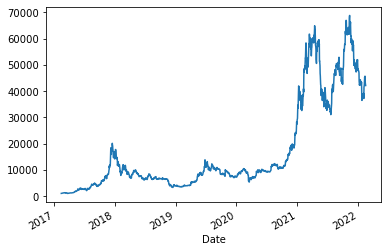

In [4]:
# Plot the data
btc["Average"].plot()

In [6]:
# Filter the date index and close columns
signals_df = btc.loc[:, ["Average"]]

# Calculate percentage change in implied volatility 
# (Implied Volatility is a proxy for option price returns) 
signals_df["Actual Returns"] = ( signals_df["Average"].pct_change())
signals_df["Actual Returns"].head()

Date
2017-02-14         NaN
2017-02-15   -0.002640
2017-02-16    0.024315
2017-02-17    0.019161
2017-02-18    0.007530
Name: Actual Returns, dtype: float64

In [7]:
# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Display sample data
signals_df.head()

,Average,Actual Returns
Date,,
2017-02-15,1008.840027,-0.002640
2017-02-16,1033.369995,0.024315
2017-02-17,1053.170044,0.019161
2017-02-18,1061.099976,0.007530
2017-02-19,1056.810059,-0.004043


# Build a Simple Trading Algorithm

In [8]:
# Set the short window and long window
short_window = 1
long_window = 5

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df["SMA_Fast"] = signals_df["Average"].rolling(window=short_window).mean()
signals_df["SMA_Slow"] = signals_df["Average"].rolling(window=long_window).mean()

# Drop any NaN
signals_df = signals_df.dropna()

# Define a Simple Momentum Strategy

In [11]:
# Initialize the new Signal column
signals_df["Signal"] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df["Actual Returns"] >= 0), "Signal"] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df["Actual Returns"] < 0), "Signal"] = -1

signals_df.head()

,Average,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2017-02-19,1056.810059,-0.004043,1056.810059,1042.658020,-1.0
2017-02-20,1080.489990,0.022407,1080.489990,1056.988013,1.0
2017-02-21,1117.250000,0.034022,1117.250000,1073.764014,1.0
2017-02-22,1125.390015,0.007286,1125.390015,1088.208008,1.0
2017-02-23,1176.619995,0.045522,1176.619995,1111.312012,1.0


# Risk and Performance


In [12]:
# Annualized volatility of the option returns for Google
annualized_volatility = round(signals_df["Actual Returns"].std() * np.sqrt(252) * 100, 2)

# Display results
print("Annualized Volatility:", annualized_volatility, "%")

Annualized Volatility: 58.15 %


In [15]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df["Strategy Returns"] = signals_df["Actual Returns"] * signals_df["Signal"].shift()
signals_df.head()

,Average,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2017-02-19,1056.810059,-0.004043,1056.810059,1042.658020,-1.0,NaN
2017-02-20,1080.489990,0.022407,1080.489990,1056.988013,1.0,-0.022407
2017-02-21,1117.250000,0.034022,1117.250000,1073.764014,1.0,0.034022
2017-02-22,1125.390015,0.007286,1125.390015,1088.208008,1.0,0.007286
2017-02-23,1176.619995,0.045522,1176.619995,1111.312012,1.0,0.045522


<AxesSubplot:xlabel='Date'>

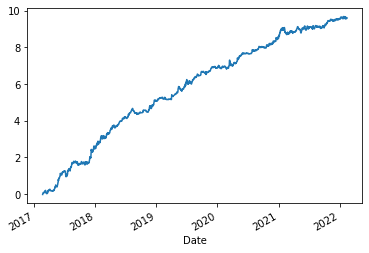

In [16]:
# Calculate the strategy's returns
strategy_returns = signals_df["Strategy Returns"].cumsum()

# Plot Strategy Returns to examine performance
strategy_returns.plot()

# Add Transaction Costs to a Backtest


In [17]:
# Every time we change from long to short, or vice-versa, 2 trades occur
signals_df["Trades"] = np.abs(signals_df["Signal"].diff())

# Display sample data
signals_df.head()

,Average,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Trades
Date,,,,,,,
2017-02-19,1056.810059,-0.004043,1056.810059,1042.658020,-1.0,NaN,NaN
2017-02-20,1080.489990,0.022407,1080.489990,1056.988013,1.0,-0.022407,2.0
2017-02-21,1117.250000,0.034022,1117.250000,1073.764014,1.0,0.034022,0.0
2017-02-22,1125.390015,0.007286,1125.390015,1088.208008,1.0,0.007286,0.0
2017-02-23,1176.619995,0.045522,1176.619995,1111.312012,1.0,0.045522,0.0


In [22]:
# Calculate total daily trade costs
cost_per_trade = 0.005
daily_trade_costs = signals_df["Trades"] * cost_per_trade

# Display sample data
daily_trade_costs.head()

Date
2017-02-19     NaN
2017-02-20    0.01
2017-02-21    0.00
2017-02-22    0.00
2017-02-23    0.00
Name: Trades, dtype: float64

In [23]:
# Calculate strategy returns after costs
signals_df["Strategy Returns (After Costs)"] = signals_df["Strategy Returns"] - daily_trade_costs


# Plot the stragegy returns before and after costs


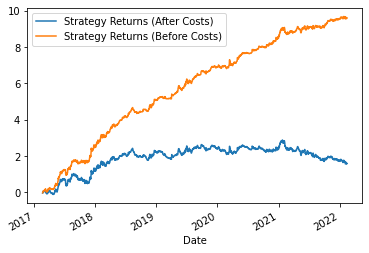

In [24]:
# Compute total strategy returns after costs
strategy_returns_after_costs = signals_df["Strategy Returns (After Costs)"].cumsum()

# Plot stategy returns before and after costs
strategy_returns_after_costs.plot(label="Strategy Returns (After Costs)")
strategy_returns.plot(label="Strategy Returns (Before Costs)")
plt.legend()

# Other Performance Metrics


## Sharpe Ratio


In [26]:
# Calculate Sharpe Ratio
annualized_return = signals_df["Strategy Returns"].mean() * 252 
annualized_std = signals_df["Strategy Returns"].std() * np.sqrt(252)
sharpe_ratio = round(annualized_return/annualized_std, 3)

# Display results
print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 2.302


# Best-Case/Worst-Case Weekly Performance


In [27]:
# Calculate weekly returns
weekly_returns = signals_df["Strategy Returns"].groupby(
        by=[
            signals_df.index.year,
            signals_df.index.week
        ]
    ).cumsum()

# Display results    
weekly_returns.head()

C:\Users\wesleyromero308\Anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


Date
2017-02-19         NaN
2017-02-20   -0.022407
2017-02-21    0.011615
2017-02-22    0.018900
2017-02-23    0.064422
Name: Strategy Returns, dtype: float64

In [28]:
# Fetch descriptive statistics
weekly_returns.describe()

count    1820.000000
mean        0.023034
std         0.072662
min        -0.276753
25%        -0.016527
50%         0.014805
75%         0.059757
max         0.416151
Name: Strategy Returns, dtype: float64

<AxesSubplot:xlabel='Date'>

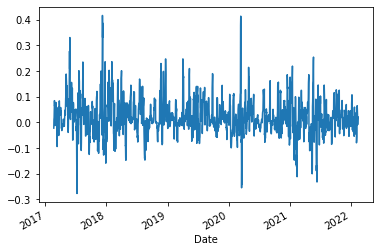

In [29]:
# Plot weekly returns
weekly_returns.plot()